# Fidelity
This notebook analyzes the correlation between tree ensemble predictions and TREX's predictions.

In [1]:
import os
import sys
sys.path.insert(0, os.getcwd() + '/../')  # for scripts
sys.path.insert(0, os.getcwd() + '/../../')  # for util

from scripts.fidelity import fidelity
data_dir = '../../data'

/Users/Jonny/Documents/research/interpretability/classification/trees/myenv/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Adult

time: 73.957s


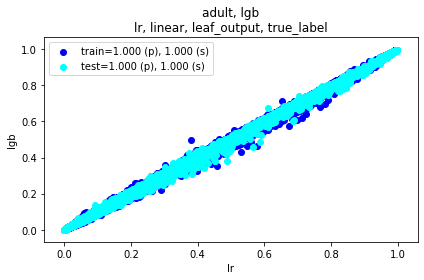

In [4]:
fidelity(model='lgb', dataset='adult', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir)

time: 244.423s


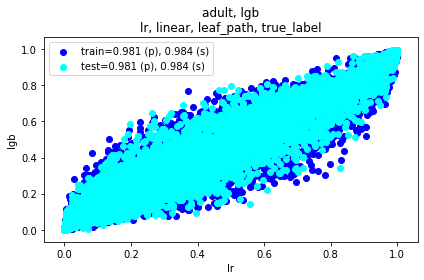

In [7]:
fidelity(model='lgb', dataset='adult', n_estimators=100, kernel='linear', encoding='leaf_path',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir)

time: 78.135s


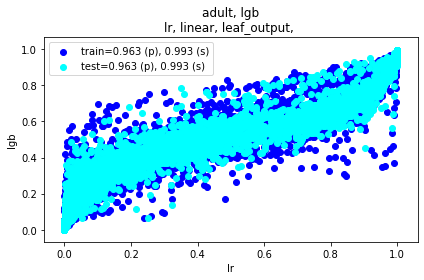

In [3]:
fidelity(model='lgb', dataset='adult', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=False, random_state=1, data_dir=data_dir)

time: 78.075s


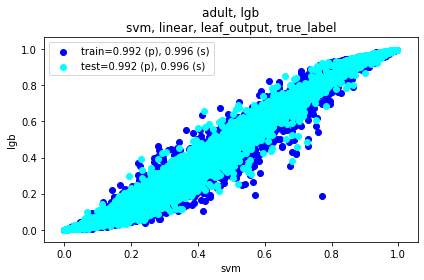

In [8]:
fidelity(model='lgb', dataset='adult', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='svm', true_label=True, use_sigmoid=True, random_state=1, data_dir=data_dir)

## Amazon

time: 52.321s


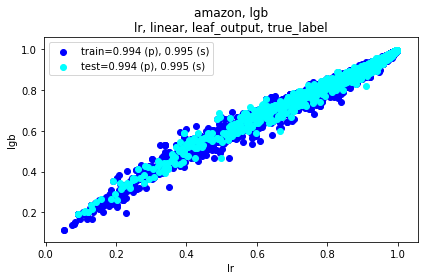

In [9]:
fidelity(model='lgb', dataset='amazon', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir)

time: 136.981s


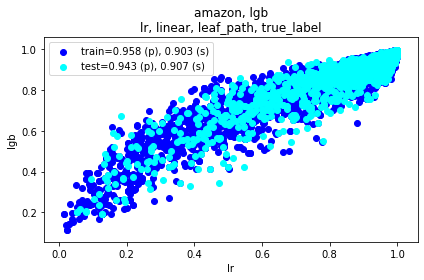

In [10]:
fidelity(model='lgb', dataset='amazon', n_estimators=100, kernel='linear', encoding='leaf_path',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir)

time: 50.480s


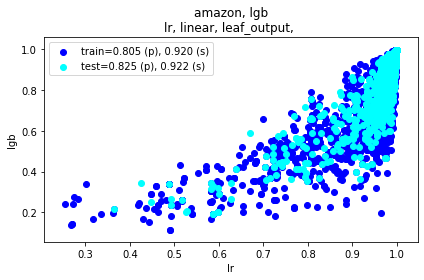

In [11]:
fidelity(model='lgb', dataset='amazon', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=False, random_state=1, data_dir=data_dir)

time: 32.886s


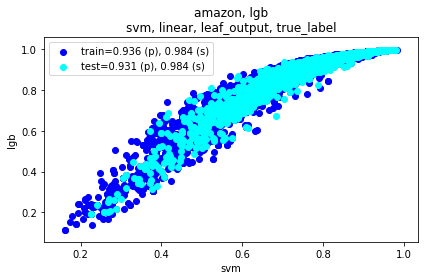

In [12]:
fidelity(model='lgb', dataset='amazon', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='svm', true_label=True, use_sigmoid=True, random_state=1, data_dir=data_dir)

## Churn

time: 8.301s


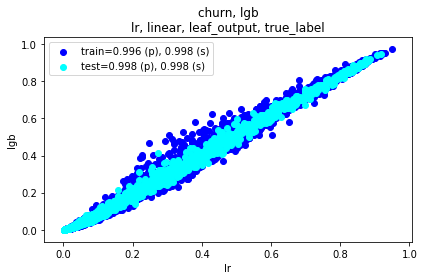

In [15]:
fidelity(model='lgb', dataset='churn', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir)

time: 8.342s


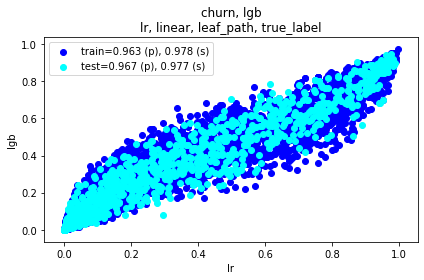

In [16]:
fidelity(model='lgb', dataset='churn', n_estimators=100, kernel='linear', encoding='leaf_path',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir)

time: 8.375s


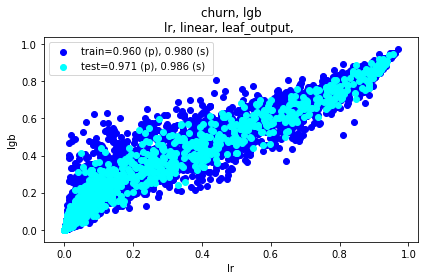

In [17]:
fidelity(model='lgb', dataset='churn', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=False, random_state=1, data_dir=data_dir)

time: 6.487s


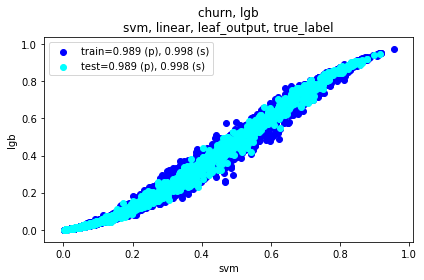

In [18]:
fidelity(model='lgb', dataset='churn', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='svm', true_label=True, use_sigmoid=True, random_state=1, data_dir=data_dir)

## NC17_MFC18

time: 11.193s


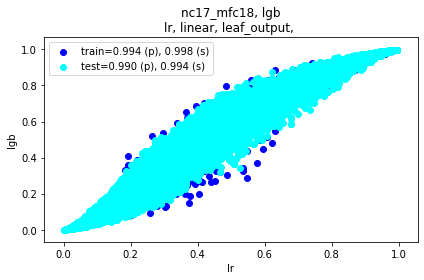

In [4]:
fidelity(model='lgb', dataset='nc17_mfc18', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=False, use_sigmoid=True, random_state=1, data_dir=data_dir)

time: 11.632s


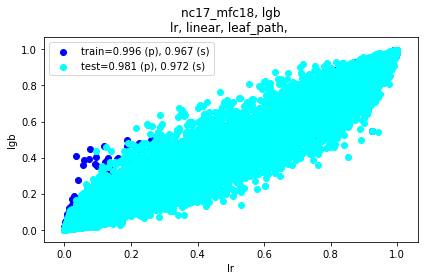

In [5]:
fidelity(model='lgb', dataset='nc17_mfc18', n_estimators=100, kernel='linear', encoding='leaf_path',
         linear_model='lr', true_label=False, use_sigmoid=True, random_state=1, data_dir=data_dir)

## Changing the Number of Trees

time: 26.104s


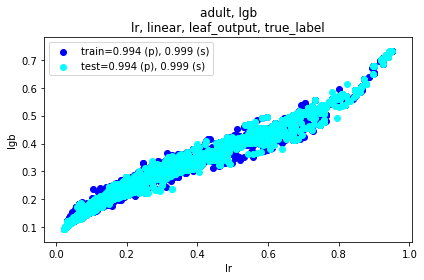

In [2]:
fidelity(model='lgb', dataset='adult', n_estimators=10, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir)

time: 543.105s


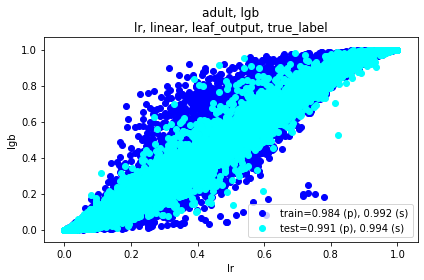

In [3]:
fidelity(model='lgb', dataset='adult', n_estimators=1000, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir)

time: 16.206s


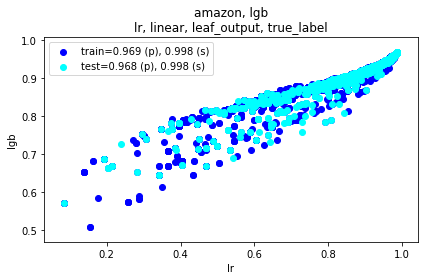

In [4]:
fidelity(model='lgb', dataset='amazon', n_estimators=10, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir)

time: 389.565s


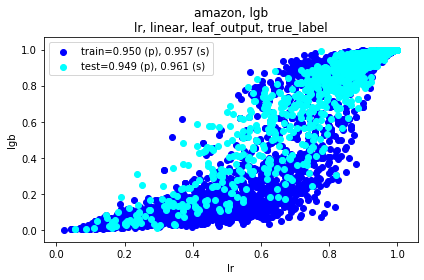

In [6]:
fidelity(model='lgb', dataset='amazon', n_estimators=1000, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir)

time: 1.678s


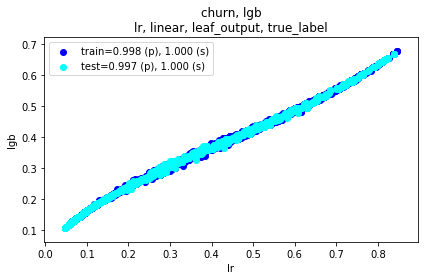

In [7]:
fidelity(model='lgb', dataset='churn', n_estimators=10, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir)

time: 77.967s


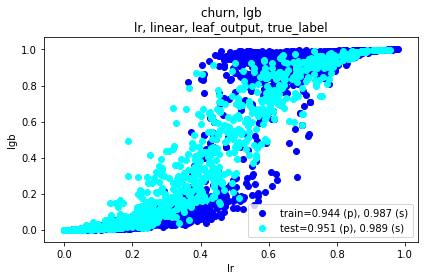

In [8]:
fidelity(model='lgb', dataset='churn', n_estimators=1000, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir)

## Changing Max Depth

time: 69.251s


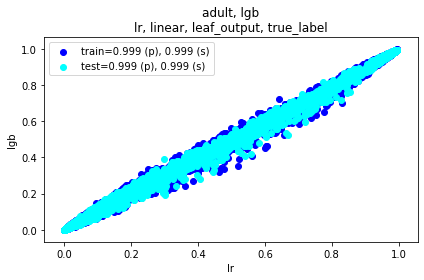

In [2]:
fidelity(model='lgb', dataset='adult', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, max_depth=3)

time: 85.637s


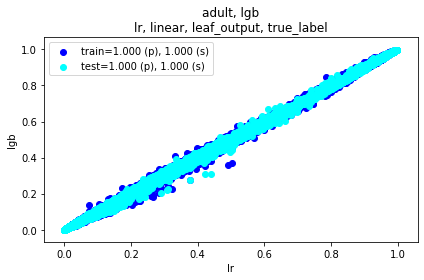

In [3]:
fidelity(model='lgb', dataset='adult', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, max_depth=5)

## Changing C

time: 79.863s


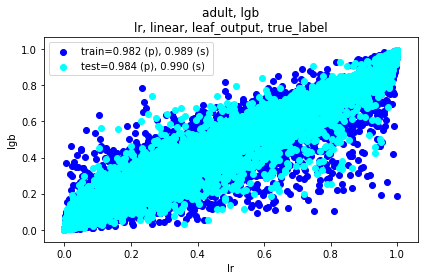

In [4]:
fidelity(model='lgb', dataset='adult', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=1)

time: 79.022s


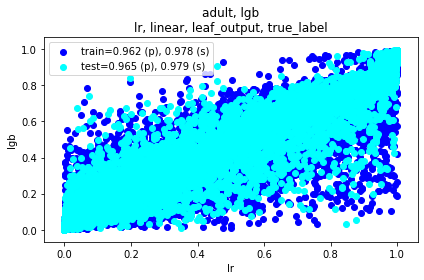

In [5]:
fidelity(model='lgb', dataset='adult', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=10)

time: 88.004s


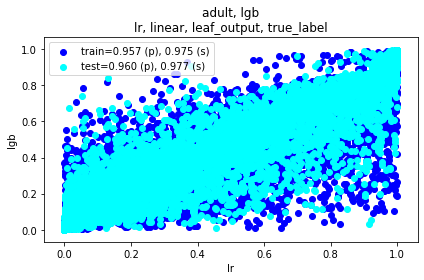

In [6]:
fidelity(model='lgb', dataset='adult', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=100)

time: 89.970s


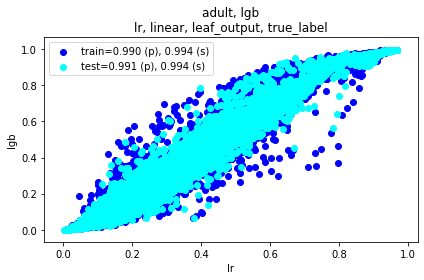

In [7]:
fidelity(model='lgb', dataset='adult', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=0.01)

time: 50.084s


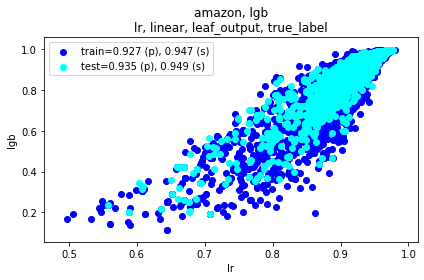

In [4]:
fidelity(model='lgb', dataset='amazon', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=0.01)

time: 50.471s


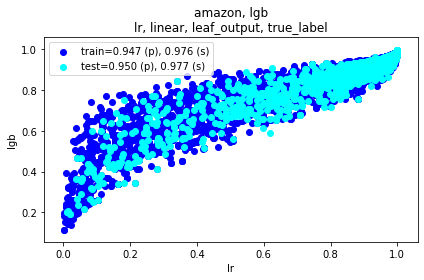

In [5]:
fidelity(model='lgb', dataset='amazon', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=1)

time: 52.452s


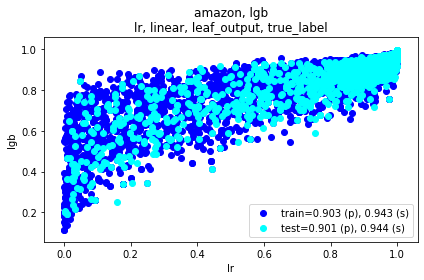

In [6]:
fidelity(model='lgb', dataset='amazon', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=10)

time: 65.301s


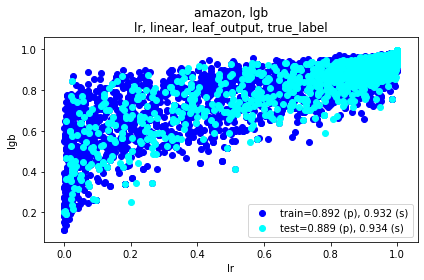

In [7]:
fidelity(model='lgb', dataset='amazon', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=100)

time: 9.156s


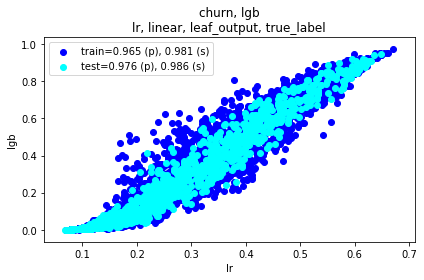

In [8]:
fidelity(model='lgb', dataset='churn', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=0.01)

time: 10.319s


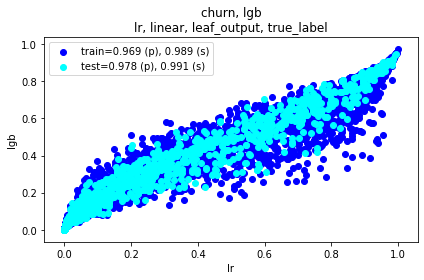

In [9]:
fidelity(model='lgb', dataset='churn', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=1)

time: 9.257s


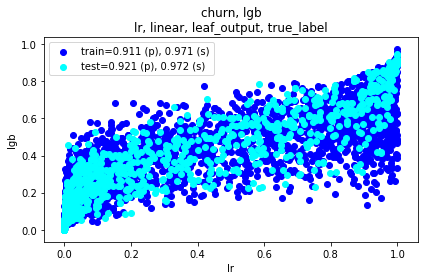

In [10]:
fidelity(model='lgb', dataset='churn', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=10)

time: 11.848s


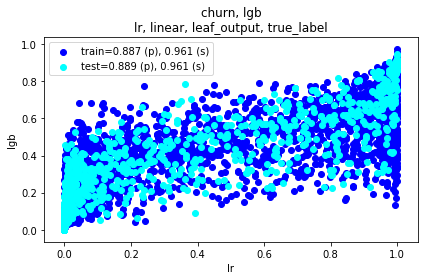

In [11]:
fidelity(model='lgb', dataset='churn', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=100)

## Changing Multiple Variables at a Time

time: 70.492s


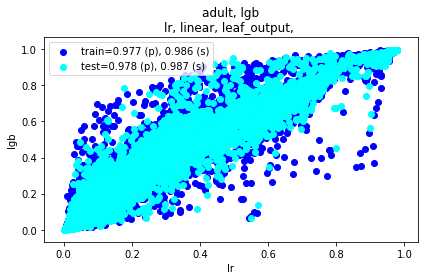

In [8]:
fidelity(model='lgb', dataset='adult', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=False, random_state=1, data_dir=data_dir, C=0.01)

time: 516.697s


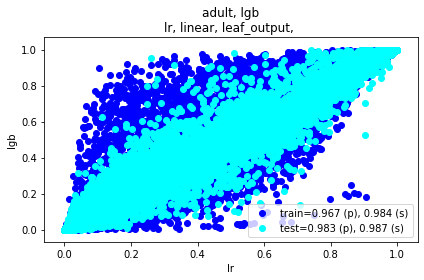

In [9]:
fidelity(model='lgb', dataset='adult', n_estimators=1000, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=False, random_state=1, data_dir=data_dir, C=0.1)

time: 521.156s


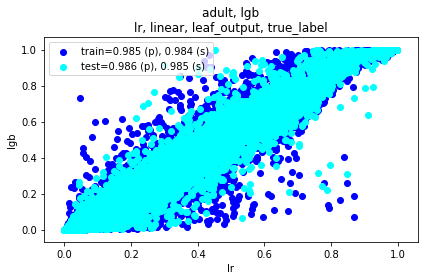

In [10]:
fidelity(model='lgb', dataset='adult', n_estimators=1000, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=0.1, max_depth=3)

time: 129.235s


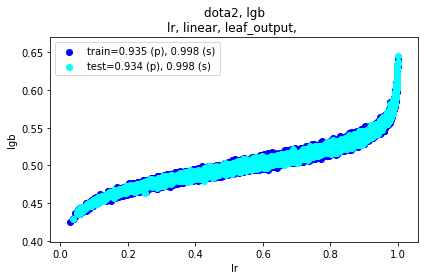

In [12]:
fidelity(model='lgb', dataset='dota2', n_estimators=10, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=False, random_state=1, data_dir=data_dir, C=0.1)

time: 130.704s


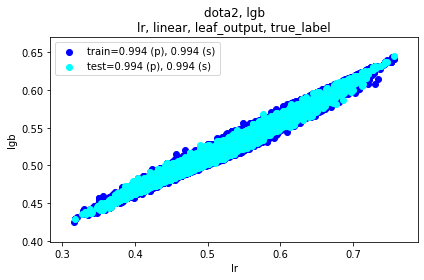

In [13]:
fidelity(model='lgb', dataset='dota2', n_estimators=10, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=0.1)

time: 305.012s


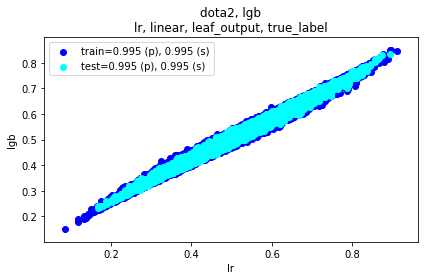

In [14]:
fidelity(model='lgb', dataset='dota2', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=0.1)

time: 891.810s


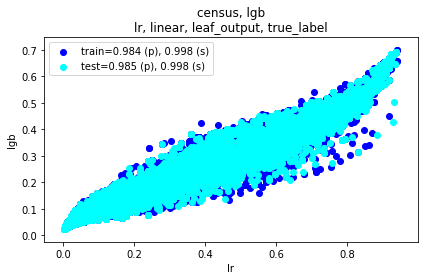

In [2]:
fidelity(model='lgb', dataset='census', n_estimators=10, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=0.1)

time: 1274.264s


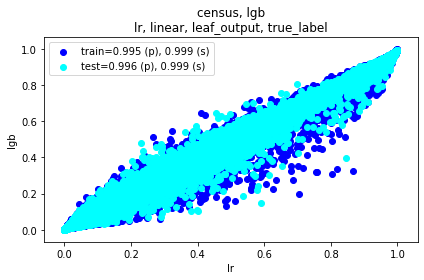

In [3]:
fidelity(model='lgb', dataset='census', n_estimators=100, kernel='linear', encoding='leaf_output',
         linear_model='lr', true_label=True, random_state=1, data_dir=data_dir, C=0.1)